#1 부정감정 지속 분석

#1.1 기본 설정

In [1]:
!pip install fsspec==2024.9.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
!pip install datasets==3.1.0 fsspec[http]==2024.9.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.4 MB/s eta 0:00:00


In [3]:
!pip install transformers torch datasets scikit-learn tqdm

#1.2 데이터셋 불러오기

데이터 로드 및 전처리

In [4]:
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# 데이터 로드 (NSMC 데이터셋)
dataset = load_dataset("e9t/nsmc")  # Naver Sentiment Movie Corpus

# 데이터프레임 변환
data = dataset['train'].to_pandas()
data = data.rename(columns={"document": "text", "label": "label"})

# 데이터 중복 제거
data = data.drop_duplicates(subset=['text'])

# 사용자 ID 생성 (1,000명의 사용자 임의 생성)
data['user_id'] = np.random.randint(1, 1001, size=len(data))

# 데이터 분할
train_data, val_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

# 데이터 크기 확인
print(f"Train Data Size: {len(train_data)}, Validation Data Size: {len(val_data)}")
print("Train Class Distribution:", train_data['label'].value_counts())
print("Validation Class Distribution:", val_data['label'].value_counts())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

nsmc.py:   0%|          | 0.00/3.18k [00:00<?, ?B/s]

The repository for e9t/nsmc contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/e9t/nsmc.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train Data Size: 116946, Validation Data Size: 29237
Train Class Distribution: label
0    58673
1    58273
Name: count, dtype: int64
Validation Class Distribution: label
0    14669
1    14568
Name: count, dtype: int64


#1.2 모델준비

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification

# KoBERT Tokenizer 및 모델 로드
tokenizer = BertTokenizer.from_pretrained("monologg/kobert")
model = BertForSequenceClassification.from_pretrained("monologg/kobert", num_labels=2)  # 긍정/부정 분류


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#1.4 데이터로더 및 Pytorch dataset


In [6]:
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import PreTrainedTokenizer

# PyTorch Dataset 클래스 정의
class EmotionDataset(Dataset):
    def __init__(self, data, tokenizer: PreTrainedTokenizer, max_len=128):
        self.texts = data['text'].tolist()
        self.labels = data['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# DataLoader 생성
train_dataset = EmotionDataset(train_data, tokenizer)
val_dataset = EmotionDataset(val_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


#1.5 Training

In [7]:
from transformers import TrainingArguments, Trainer

# TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2
)


def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 학습 시작
trainer.train()

# 평가
eval_results = trainer.evaluate()
print(f"Validation Results: {eval_results}")

torch.save(model, "trained_baseline_model.pth")
print("Model saved successfully!")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-7-9890c37b5a18>:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:


Abort: 

#2 시계열 분석 + KoBERT

부정 감정 지속성 분석



#2.1 기본 설정

In [ ]:
!pip uninstall torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchfrtrace
    /usr/local/bin/torchrun
    /usr/local/lib/python3.10/dist-packages/functorch/*
    /usr/local/lib/python3.10/dist-packages/torch-2.5.1+cu121.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torch/*
    /usr/local/lib/python3.10/dist-packages/torchgen/*
Proceed (Y/n)? y
y
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/torchvision-0.20.1+cu121.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libcudart.7ec1eba6.so.12
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libnvjpeg.f00ca762.so.12
    /usr/local

#2.2 데이터 전처리

In [7]:
import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import BertTokenizer, BertModel, Trainer, TrainingArguments
import numpy as np
from datetime import datetime, timedelta

# 데이터셋 로드 및 전처리
dataset = load_dataset("nsmc")
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def generate_time_series(num_samples):
    """시계열 데이터 생성"""
    base_time = datetime(2022, 1, 1)
    time_series_data = []
    for i in range(num_samples):
        random_offset = timedelta(minutes=np.random.randint(0, 1440))
        current_time = base_time + random_offset
        time_series_data.append([current_time.hour, current_time.minute])  # (hour, minute)
    return time_series_data

def preprocess_function(examples):
    """코멘트 데이터 전처리 및 시계열 데이터 추가"""
    tokenized_inputs = tokenizer(examples['document'], truncation=True, padding='max_length', max_length=128)
    time_series_data = generate_time_series(len(examples['document']))
    tokenized_inputs['time_series'] = torch.tensor(time_series_data, dtype=torch.float32).unsqueeze(1)  # (batch_size, seq_len=1, input_dim=2)
    tokenized_inputs['labels'] = torch.tensor(examples['label'], dtype=torch.long)
    return tokenized_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'time_series', 'labels'])

README.md:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

nsmc.py:   0%|          | 0.00/3.18k [00:00<?, ?B/s]

The repository for nsmc contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/nsmc.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

#2.3 모델 정의


In [ ]:
import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import BertTokenizer, BertModel, Trainer, TrainingArguments
import numpy as np
from datetime import datetime, timedelta

# 모델 정의
class BertWithTimeSeries(nn.Module):
    def __init__(self):
        super(BertWithTimeSeries, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.classifier = nn.Linear(self.bert.config.hidden_size + 2, 2)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, time_series, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        pooled_output = outputs.pooler_output

        combined_input = torch.cat((pooled_output, time_series.squeeze(1)), dim=1)
        logits = self.classifier(combined_input)

        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return loss, logits
        return logits

model = BertWithTimeSeries()

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    data_collator=None,
    compute_metrics=None,
)

# 학습 시작
trainer.train()

# 모델 저장
torch.save(model.state_dict(), "trained_augmented_model.pth")
print("Model saved successfully!")

#3 Baseline과 증강모델 비교

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-9daf963d76c2>:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  baseline_trainer = Trainer(


Training Baseline Model...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.371600,0.342376,0.850140,0.850298,0.850140,0.850109
2,0.300600,0.322350,0.861740,0.863556,0.861740,0.861607
3,0.224700,0.336594,0.868800,0.868800,0.868800,0.868800


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-9daf963d76c2>:119: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  time_series_trainer = Trainer(



Training Time Series Model...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.354200,0.329521,0.853640,0.853706,0.853640,0.853624
2,0.286700,0.311739,0.869460,0.869671,0.869460,0.869453
3,0.207800,0.332441,0.872680,0.872745,0.872680,0.872667


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



Training Time Series Model with EarlyStopping...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.353100,0.330382,0.854700,0.854708,0.854700,0.854701
2,0.292400,0.311581,0.866360,0.866476,0.866360,0.866358
3,0.205000,0.347778,0.869560,0.869720,0.869560,0.869534



Baseline Results: {'eval_loss': 0.33659350872039795, 'eval_accuracy': 0.8688, 'eval_precision': 0.8687996491583879, 'eval_recall': 0.8688, 'eval_f1': 0.8687997745343613, 'eval_runtime': 164.4822, 'eval_samples_per_second': 303.984, 'eval_steps_per_second': 4.754, 'epoch': 3.0}

Time Series Results: {'eval_loss': 0.3324408233165741, 'eval_accuracy': 0.87268, 'eval_precision': 0.8727454122531554, 'eval_recall': 0.87268, 'eval_f1': 0.8726669447396591, 'eval_runtime': 165.4066, 'eval_samples_per_second': 302.285, 'eval_steps_per_second': 4.728, 'epoch': 3.0}

Time Series + EarlyStopping Results: {'eval_loss': 0.31158143281936646, 'eval_accuracy': 0.86636, 'eval_precision': 0.8664757934848661, 'eval_recall': 0.86636, 'eval_f1': 0.8663584951039046, 'eval_runtime': 164.5759, 'eval_samples_per_second': 303.811, 'eval_steps_per_second': 4.752, 'epoch': 3.0}


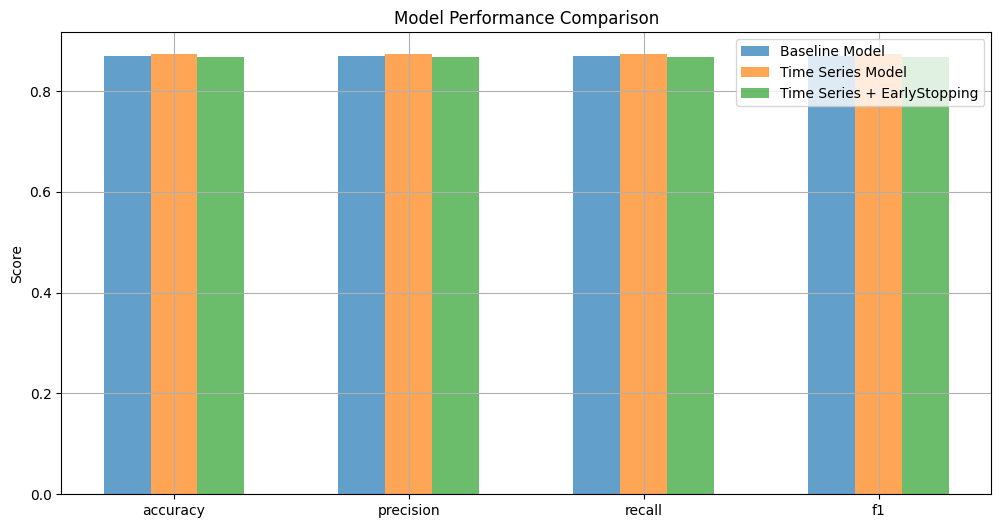

In [12]:
import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import BertTokenizer, BertModel, Trainer, TrainingArguments, EarlyStoppingCallback
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 데이터셋 로드 및 전처리
dataset = load_dataset("nsmc")
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

def generate_time_series(num_samples):
    """시계열 데이터 생성"""
    base_time = datetime(2022, 1, 1)
    time_series_data = []
    for _ in range(num_samples):
        random_offset = timedelta(minutes=np.random.randint(0, 1440))
        current_time = base_time + random_offset
        time_series_data.append([current_time.hour, current_time.minute])  # (hour, minute)
    return time_series_data

def preprocess_function(examples):
    """코멘트 데이터 전처리 및 시계열 데이터 추가"""
    tokenized_inputs = tokenizer(examples["document"], truncation=True, padding="max_length", max_length=128)
    time_series_data = generate_time_series(len(examples["document"]))
    tokenized_inputs["time_series"] = torch.tensor(time_series_data, dtype=torch.float32)  # 시간 데이터
    tokenized_inputs["labels"] = torch.tensor(examples["label"], dtype=torch.long)
    return tokenized_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "time_series", "labels"])

# Baseline 모델 정의
baseline_model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)

# Time Series 모델 정의
class BertWithTimeSeries(nn.Module):
    def __init__(self):
        super(BertWithTimeSeries, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.classifier = nn.Linear(self.bert.config.hidden_size + 2, 2)  # BERT hidden size + 2 for time series
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, time_series, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        combined_input = torch.cat((pooled_output, time_series), dim=1)
        logits = self.classifier(combined_input)
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

time_series_model = BertWithTimeSeries()
earlystop_model = BertWithTimeSeries()

# DataCollator 정의
class CustomDataCollator:
    def __call__(self, features):
        input_ids = torch.stack([f["input_ids"] for f in features])
        attention_mask = torch.stack([f["attention_mask"] for f in features])
        time_series = torch.stack([f["time_series"] for f in features])
        labels = torch.tensor([f["labels"] for f in features])
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "time_series": time_series,
            "labels": labels,
        }

data_collator = CustomDataCollator()

# 평가 함수 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Baseline 모델 훈련
baseline_training_args = TrainingArguments(
    output_dir="./results_baseline",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
)

baseline_trainer = Trainer(
    model=baseline_model,
    args=baseline_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

print("Training Baseline Model...")
baseline_trainer.train()
baseline_results = baseline_trainer.evaluate()

# Time Series 모델 훈련
time_series_training_args = TrainingArguments(
    output_dir="./results_time_series",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
)

time_series_trainer = Trainer(
    model=time_series_model,
    args=time_series_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

print("\nTraining Time Series Model...")
time_series_trainer.train()
time_series_results = time_series_trainer.evaluate()

# Time Series + EarlyStopping 모델 훈련
earlystop_training_args = TrainingArguments(
    output_dir="./results_earlystop",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

earlystop_trainer = Trainer(
    model=earlystop_model,
    args=earlystop_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    compute_metrics=compute_metrics
)

print("\nTraining Time Series Model with EarlyStopping...")
earlystop_trainer.train()
earlystop_results = earlystop_trainer.evaluate()

# 결과 출력
print("\nBaseline Results:", baseline_results)
print("\nTime Series Results:", time_series_results)
print("\nTime Series + EarlyStopping Results:", earlystop_results)

# 시각화
metrics = ["accuracy", "precision", "recall", "f1"]
baseline_scores = [baseline_results[f"eval_{metric}"] for metric in metrics]
time_series_scores = [time_series_results[f"eval_{metric}"] for metric in metrics]
earlystop_scores = [earlystop_results[f"eval_{metric}"] for metric in metrics]

x = np.arange(len(metrics))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - width, baseline_scores, width, label="Baseline Model", alpha=0.7)
plt.bar(x, time_series_scores, width, label="Time Series Model", alpha=0.7)
plt.bar(x + width, earlystop_scores, width, label="Time Series + EarlyStopping", alpha=0.7)
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(True)
plt.show()
